In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
dataset = pd.read_csv('inventory.csv')
dataset.head()

,sku_id,date,stock_level,restock_flag,supplier_lead_time
0,P0859,2024-02-27,25,0.0,4.0
1,P0900,2025-05-03,89,0.0,6.0
2,P0671,2023-07-27,72,0.0,4.0
3,P0510,2023-09-21,65,0.0,10.0
4,P0438,2024-06-04,0,0.0,8.0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sku_id              65000 non-null  object 
 1   date                65000 non-null  object 
 2   stock_level         65000 non-null  int64  
 3   restock_flag        64371 non-null  float64
 4   supplier_lead_time  63038 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5+ MB


In [ ]:
df_inven = dataset.copy()
df_inven.head()

,sku_id,date,stock_level,restock_flag,supplier_lead_time
0,P0859,2024-02-27,25,0.0,4.0
1,P0900,2025-05-03,89,0.0,6.0
2,P0671,2023-07-27,72,0.0,4.0
3,P0510,2023-09-21,65,0.0,10.0
4,P0438,2024-06-04,0,0.0,8.0


In [ ]:
df_inven.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65000 entries, 0 to 64999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sku_id              65000 non-null  object 
 1   date                65000 non-null  object 
 2   stock_level         65000 non-null  int64  
 3   restock_flag        64371 non-null  float64
 4   supplier_lead_time  63038 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5+ MB


In [ ]:
df_inven.shape

(65000, 5)

In [ ]:
df_inven.columns

Index(['sku_id', 'date', 'stock_level', 'restock_flag', 'supplier_lead_time'], dtype='object')

In [ ]:
# Checking for Missing Values
print( df_inven.isnull().sum())
print("----------------------------------")
print("Missing value percentage")
print(df_inven.isnull().mean().sort_values(ascending=False) * 100 )


sku_id                   0
date                     0
stock_level              0
restock_flag           629
supplier_lead_time    1962
dtype: int64
----------------------------------
Missing value percentage
supplier_lead_time    3.018462
restock_flag          0.967692
sku_id                0.000000
stock_level           0.000000
date                  0.000000
dtype: float64


**supplier_lead_time:** We don’t want to drop rows because lead time affects pricing, availability, and RL reward design. Median is robust to outliers.

**restock_flag:** Since it's <1% missing, mode imputation is safe. RL logic may use this for supply state (e.g., action space constraints).



In [ ]:
df_inven['supplier_lead_time'] = df_inven['supplier_lead_time'].fillna(df_inven['supplier_lead_time'].median())

In [ ]:
df_inven['restock_flag'] = df_inven['restock_flag'].fillna(df_inven['restock_flag'].mode()[0])

In [ ]:
df_inven.isnull().sum()

,0
sku_id,0
date,0
stock_level,0
restock_flag,0
supplier_lead_time,0


In [ ]:
duplicate_rows = df_inven[df_inven.duplicated()]
print(f"\n Total Duplicate Rows: {duplicate_rows.shape[0]}")


 Total Duplicate Rows: 1


In [ ]:
df_inven = df_inven.drop_duplicates()
print("Duplicate row removed. Shape is now:", df_inven.shape)


Duplicate row removed. Shape is now: (64999, 5)


#  Outlier Identification and  Detection

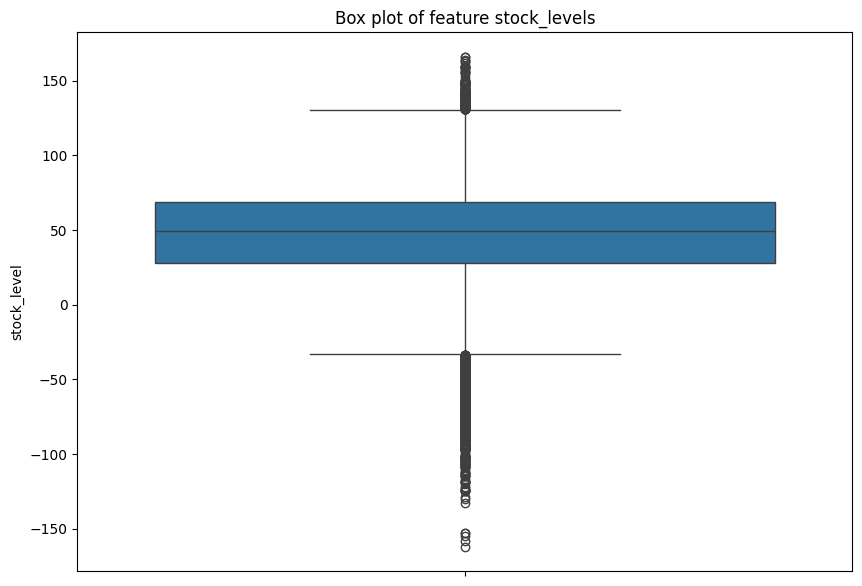

In [ ]:
# stock levels

plt.figure(figsize = (10, 7))
sns.boxplot(data=df_inven['stock_level'])
plt.title("Box plot of feature stock_levels")
plt.show()

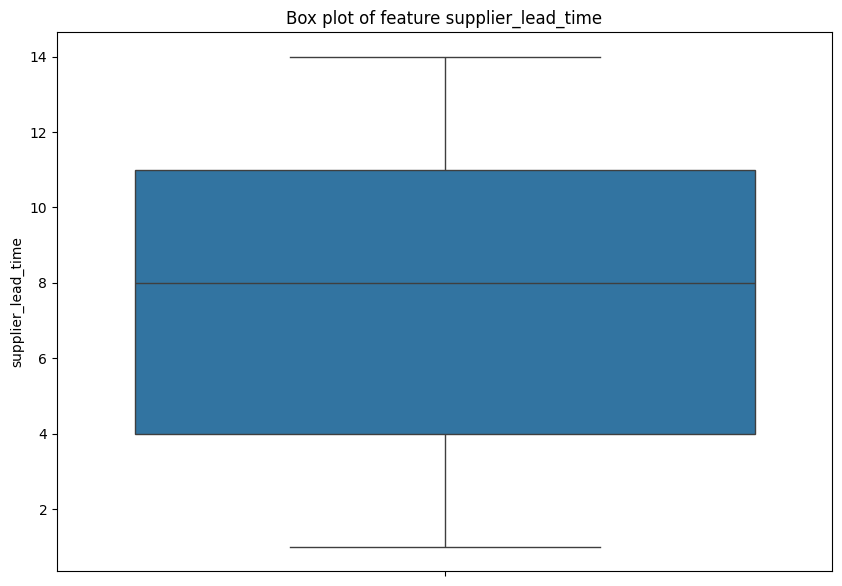

In [ ]:
plt.figure(figsize = (10, 7))
sns.boxplot(data=df_inven['supplier_lead_time'])
plt.title("Box plot of feature supplier_lead_time")
plt.show()

In [ ]:
# negative stock values to 0
df_inven['stock_level'] = df_inven['stock_level'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
print("Negative stock values after fix:", (df_inven['stock_level'] < 0).sum())


Negative stock values after fix: 0


In [ ]:
# Compute 1st and 99th percentiles
lower_cap = df_inven['stock_level'].quantile(0.01)
upper_cap = df_inven['stock_level'].quantile(0.99)

# Cap values outside this range
df_inven['stock_level_capped'] = df_inven['stock_level'].clip(lower=lower_cap, upper=upper_cap)


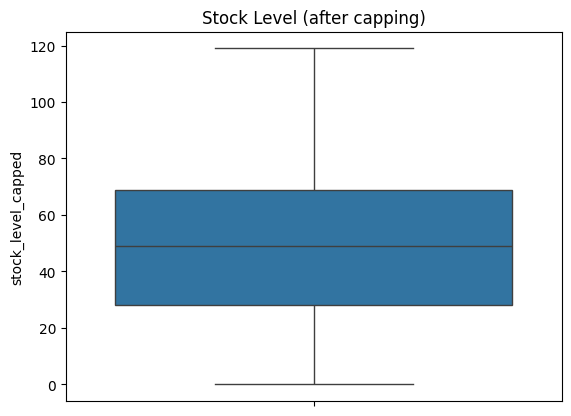

In [ ]:
sns.boxplot(y=df_inven['stock_level_capped'])
plt.title('Stock Level (after capping)')
plt.show()

## Standardizing Data Types & Formatting

In [ ]:
df_inven.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64999 entries, 0 to 64999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sku_id              64999 non-null  object 
 1   date                64999 non-null  object 
 2   stock_level         64999 non-null  int64  
 3   restock_flag        64999 non-null  float64
 4   supplier_lead_time  64999 non-null  float64
 5   stock_level_capped  64999 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 3.5+ MB


In [ ]:
print(df_inven['restock_flag'].unique())

[0. 1.]


In [ ]:
df_inven['restock_flag'] = df_inven['restock_flag'].astype(float).map({1.0: True, 0.0: False})


In [ ]:
df_inven.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64999 entries, 0 to 64999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sku_id              64999 non-null  object 
 1   date                64999 non-null  object 
 2   stock_level         64999 non-null  int64  
 3   restock_flag        64999 non-null  bool   
 4   supplier_lead_time  64999 non-null  float64
 5   stock_level_capped  64999 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 3.0+ MB


In [ ]:
df_inven.head(7)

,sku_id,date,stock_level,restock_flag,supplier_lead_time,stock_level_capped
0,P0859,2024-02-27,25,False,4.0,25
1,P0900,2025-05-03,89,False,6.0,89
2,P0671,2023-07-27,72,False,4.0,72
3,P0510,2023-09-21,65,False,10.0,65
4,P0438,2024-06-04,0,False,8.0,0
5,P0104,2024-05-21,0,False,9.0,0
6,P0769,2025-06-12,47,False,1.0,47


# Feature Enginnering
The goal is to understand supply-side patterns, such as:

- When SKUs go out of stock

- How often restocking happens

- Delays in supplier lead time

- Inventory turnover trends

## When SKUs Go Out of Stock

Why? If a product is out of stock or likely to be soon, there’s no point in giving discounts or spending ad budget.
In fact, some retailers increase price when inventory is low to slow down demand (“scarcity pricing”).
Feature: flag to prevent unnecessary price drops or to trigger price surge.

In [ ]:
# Why: Helps in prioritizing discounting or pausing ads for SKUs close to 0 inventory.

# Flag items below a certain stock threshold
low_stock_threshold = 10  # Or use dynamic quantile
df_inven['is_low_stock'] = (df_inven['stock_level_capped'] <= low_stock_threshold).astype(bool)

How Often Restocking Happens
Why it matters:

If a SKU is restocked frequently (e.g., every 3 days), the system can afford to be more aggressive in selling (discount, ads). If restocking is infrequent, pricing needs to be conservative — preserving stock to avoid "stockouts".

Useful Feature:

restock_flag and days_until_restock: help model the expected replenishment frequency.



In [ ]:
#Why: A product needing restock in 2 days is a higher priority than in 10. Helps model urgency and replenishment delay.

# If restock is needed, how long until it’s fulfilled?
df_inven['days_until_restock'] = df_inven['restock_flag'] * df_inven['supplier_lead_time']


## Delays in Supplier Lead Time
Why? Long lead times mean you can’t replenish fast.
This drives strategic pricing: raise prices or limit exposure when supply is slow.
supplier_lead_time: key indicator of inventory risk.
Inventory health, balances stock vs. lead time.

In [ ]:
#  Why: Gives a balanced view of supply position — low stock + long supplier delay = risk.

# Combines multiple features into one meaningful score
df_inven['inventory_health_score'] = df_inven['stock_level_capped'] / (df_inven['supplier_lead_time'] + 1)


## Inventory Turnover Trends
Why?

Fast-moving SKUs should be prioritized — they're often best-sellers.
Slow-moving or stagnant stock needs a price incentive to clear.
Helps optimize the long-term reward in reinforcement learning (like maximizing cumulative revenue or minimizing stockouts).

rolling_stock_7d: helps in,  is inventory falling, rising, or stuck?



In [ ]:
# Why: Tracks 7-day moving average of stock levels for smoothing sudden changes.
df_inven.sort_values(['sku_id', 'date'], inplace=True)
df_inven['rolling_stock_7d'] = df_inven.groupby('sku_id')['stock_level_capped'].transform(lambda x: x.rolling(7, min_periods=1).mean())


## Business Logic to Model Logic Translation:

Low inventory + long lead time = discourage price drops.

High stock + low restock flag = encourage selling (discount).

Stable stock with low movement = apply mild incentives.

Weekend with strong movement = surge pricing opportunity.

In [ ]:
df_inven.to_csv("clean_inventory.csv", index=False)